In [1]:
from utils import *

from time import time
import seaborn as sns
from sklearn.model_selection import train_test_split

# Modelos
from sksurv.ensemble import RandomSurvivalForest

import warnings
warnings.filterwarnings("ignore")

## Parametros

In [2]:
table = 'Diabetes_avicena_survival.diabetes_final_3_annos'

variables_with_outliers = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal']

variables_to_train = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal','ant_cardio','genero_paciente']

numeric_columns = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal']
categoric_columns = ['genero_paciente','raza_paciente','nivel_academico_paciente','ant_cardio','med_hipertension','ant_familiar_dm','hace_ejercicio']
columns_not_in_count = ['ant_familiar_dm', 'raza_paciente','hace_ejercicio']
target = ['time_to_event','diabetes']

dict_var_categoricas = {
    # Nivel Academico
    "Ninguno" : 'ninguno',

    "Básica secundaria" : 'educacion_basica', 
    "Básica primaria" : 'educacion_basica',

    "Normalista" : 'educacion_media',
    "Bachillerato técnico" : 'educacion_media',
    "Técnica profesional" : 'educacion_media',
    "Tecnológica" : 'educacion_media',
    "Media académica o clásica" : 'educacion_media',

    "Profesional" : 'educacion_superior',
    "Especialización" : 'educacion_superior',
    "Preescolar" : 'educacion_superior',
    "Doctorado" : 'educacion_superior',
    "Maestría" : 'educacion_superior',
        
    # Ejercicio
    'Nunca' : 'No',
    '20 minutos' : '20 min',
    '40 minutos' : 'Mas de 20 min',
    '60 minutos' : 'Mas de 20 min',

    # Dicotomicas
    "1" : 'Si',
    '0' : 'No'
    

}

## Carga de datos

In [3]:
data = client_bq.query(f'SELECT * FROM {table}').result().to_dataframe()
print(f'Se trajo {data.shape} datos de pacientes')
data.head()

Se trajo (735003, 21) datos de pacientes


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,1003390652,2022,2,2022-02-01,26,105.233333,1.60,41.106770833,71.20,106.14,...,111.0,Femenino,Mestizo,Bachillerato técnico,0,0,0,None,0,34
1,1006578626,2022,2,2022-02-01,20,68.700000,1.77,21.928564589,56.25,143.00,...,NaN,Masculino,Otros,Profesional,1,0,0,None,0,36
2,1007218577,2022,2,2022-02-01,28,74.300000,1.78,23.450321929,45.10,96.64,...,NaN,Masculino,Otros,Ninguno,0,0,0,None,0,33
3,1010021506,2022,2,2022-02-01,36,71.000000,1.60,27.734375000,60.00,140.00,...,NaN,Masculino,Otros,Tecnológica,1,1,0,None,0,35
4,10241950,2022,2,2022-02-01,67,85.800000,1.72,29.002163332,41.00,82.00,...,105.0,Masculino,Otros,Básica secundaria,1,1,0,None,1,13


In [4]:
# Quitar outliers
data_clean = take_out_outliers(data, numeric_columns, verbose = False)
print(f'Hay {data_clean.shape[0]} datos de pacientes sin outliers')
data_clean = data_clean.dropna()
print(f'Hay {data_clean.shape[0]} datos de pacientes sin nulos')
data_clean.head()

Hay 660085 datos de pacientes sin outliers
Hay 17669 datos de pacientes sin nulos


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
23,12562580,2022,2,2022-02-01,58.0,79.5,1.70,27.508651,44.6,139.40,...,97.0,Masculino,Otros,Técnica profesional,1,1,0,20 minutos,0,31
54,20482949,2022,2,2022-02-01,61.0,82.0,1.58,32.847300,53.2,130.80,...,108.0,Femenino,Otros,Básica primaria,1,0,0,Nunca,0,33
135,43715233,2022,2,2022-02-01,41.0,65.3,1.60,25.507812,54.2,110.20,...,82.0,Femenino,Otros,Profesional,0,0,0,Nunca,0,35
239,14966384,2022,2,2022-02-01,72.0,79.0,1.61,30.477219,41.3,110.00,...,111.0,Masculino,Otros,Especialización,1,1,0,Nunca,0,26
348,51778785,2022,2,2022-02-01,57.0,58.0,1.57,23.530366,50.7,157.85,...,78.0,Femenino,Otros,Ninguno,1,0,0,20 minutos,1,1


## Graficas de categorias de Ant. Cardio contra diabetes

,ant_cardio,diabetes,Conteo
0,No,No,8561
1,No,Si,2869
2,Si,No,5272
3,Si,Si,967


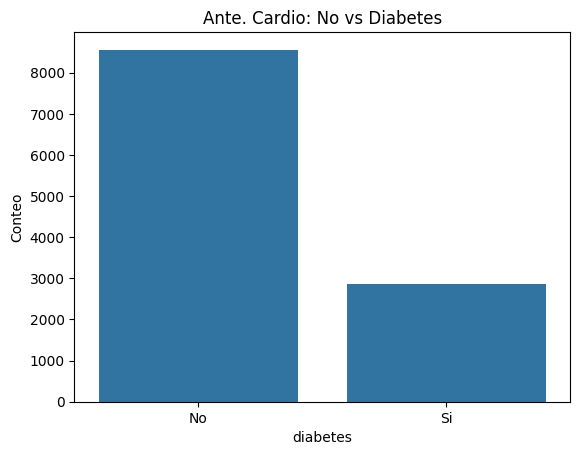

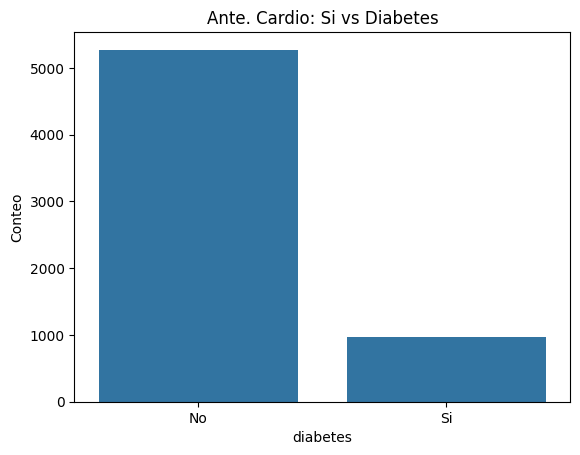

In [5]:
dict_dicotomicas = {'0': 'No', '1': 'Si'}

df_to_plot = data_clean[['edad','ant_cardio','diabetes']].astype(str)
df_to_plot = df_to_plot.groupby(['ant_cardio','diabetes'], as_index = False).count()
df_to_plot.rename(columns = {'edad': 'Conteo'}, inplace = True)
df_to_plot.diabetes = df_to_plot.diabetes.replace(dict_dicotomicas)
df_to_plot.ant_cardio = df_to_plot.ant_cardio.replace(dict_dicotomicas)
display(df_to_plot)

for genero in df_to_plot.ant_cardio.unique():
    sns.barplot(df_to_plot[df_to_plot.ant_cardio == genero], x = 'diabetes', y = 'Conteo').set_title(f'Ante. Cardio: {genero} vs Diabetes')
    plt.show()

## Proceso

In [6]:
# Dataframe con los datos numericos
df_columns = data_clean[variables_to_train]
df_columns['IMC'] = np.round(df_columns['IMC'].astype(float),2)
df_columns.genero_paciente = df_columns.genero_paciente.replace({'Femenino' : 0, 'Masculino' : 1})

print(f'Hay {df_columns.shape[0]} pacientes para entrenar la linea base')
df_columns.head()

Hay 17669 pacientes para entrenar la linea base


,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,ant_cardio,genero_paciente
23,58.0,27.51,44.6,139.40,135.89,97.0,1,1
54,61.0,32.85,53.2,130.80,194.30,108.0,1,0
135,41.0,25.51,54.2,110.20,108.00,82.0,0,0
239,72.0,30.48,41.3,110.00,181.00,111.0,1,1
348,57.0,23.53,50.7,157.85,52.06,78.0,1,0


In [7]:
# Escalar los datos
df_escalado = escalar(df_columns)
df_escalado.columns = df_columns.columns
df_escalado.head()

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,ant_cardio,genero_paciente
0,0.481928,0.499164,0.462500,0.612595,0.422700,0.35625,1.0,1.0
1,0.518072,0.722408,0.596875,0.571565,0.606651,0.42500,1.0,0.0
2,0.277108,0.415552,0.612500,0.473282,0.334866,0.26250,0.0,0.0
3,0.650602,0.623328,0.410937,0.472328,0.564766,0.44375,1.0,1.0
4,0.469880,0.332776,0.557813,0.700620,0.158694,0.23750,1.0,0.0


## Entrenamiento con ejes principales

In [8]:
## Creacion de ejes principales con ACP
components_df, pca = ACP(data = df_escalado[numeric_columns], n_comp= len(numeric_columns))
components_df.columns = df_escalado[numeric_columns].columns
components_df

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal
0,0.012801,0.059299,0.059406,0.032431,-0.089198,0.028138
1,0.188747,0.085402,0.014981,0.202209,0.127597,0.031726
2,-0.175118,-0.143252,0.030827,-0.062051,0.051318,-0.010918
3,0.188228,0.211043,-0.122571,0.073210,-0.020666,0.055777
4,-0.307303,0.010260,0.142505,0.041501,-0.205249,-0.027871
...,...,...,...,...,...,...
17664,-0.123895,0.287279,0.086498,-0.029443,0.070570,0.068733
17665,0.273749,-0.062381,-0.384173,0.223609,-0.121176,-0.002426
17666,-0.124021,0.034828,-0.187758,0.190569,0.102610,0.063389
17667,-0.306816,0.087826,0.142166,0.053171,-0.063540,-0.023684


Dimensiones retenidas (criterio de Benzécri): [0, 1]


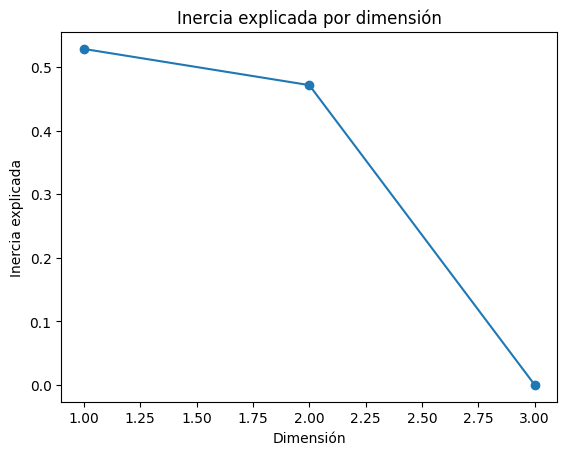

,Component_mca_0,Component_mca_1,Component_mca_2
0,1.274478,0.079044,-0.286318
1,0.258503,1.095020,-0.286318
2,-0.787665,0.048852,-0.286318
3,1.274478,0.079044,-0.286318
4,0.258503,1.095020,-0.286318
...,...,...,...
17664,0.228311,-0.967123,-0.286318
17665,-0.787665,0.048852,-0.286318
17666,0.228311,-0.967123,-0.286318
17667,-0.787665,0.048852,-0.286318


In [9]:
components_mca, mca, ejes_a_tomar_mca = MCA(data_clean[['genero_paciente','ant_cardio']], n_comp= 3)
components_mca = components_mca.reset_index().drop(columns = 'index')
components_mca

In [10]:
df_train = components_df.reset_index().merge(components_mca[ejes_a_tomar_mca].reset_index(), on = 'index', how = 'left')
df_train.drop(columns = ['index'], inplace=True)

df_train

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,Component_mca_0,Component_mca_1
0,0.012801,0.059299,0.059406,0.032431,-0.089198,0.028138,1.274478,0.079044
1,0.188747,0.085402,0.014981,0.202209,0.127597,0.031726,0.258503,1.095020
2,-0.175118,-0.143252,0.030827,-0.062051,0.051318,-0.010918,-0.787665,0.048852
3,0.188228,0.211043,-0.122571,0.073210,-0.020666,0.055777,1.274478,0.079044
4,-0.307303,0.010260,0.142505,0.041501,-0.205249,-0.027871,0.258503,1.095020
...,...,...,...,...,...,...,...,...
17664,-0.123895,0.287279,0.086498,-0.029443,0.070570,0.068733,0.228311,-0.967123
17665,0.273749,-0.062381,-0.384173,0.223609,-0.121176,-0.002426,-0.787665,0.048852
17666,-0.124021,0.034828,-0.187758,0.190569,0.102610,0.063389,0.228311,-0.967123
17667,-0.306816,0.087826,0.142166,0.053171,-0.063540,-0.023684,-0.787665,0.048852


In [11]:
# Creacion variable target
target = data_clean[['diabetes','time_to_event']]
target['target'] = target.apply(lambda x: (bool(x.diabetes), x.time_to_event), axis = 1)
target = target['target']
target = np.array(target, dtype=[('event', np.bool_), ('time', np.int32)])

target[:5]

array([(False, 31), (False, 33), (False, 35), (False, 26), ( True,  1)],
      dtype=[('event', '?'), ('time', '<i4')])

In [12]:
print('Data final para entrenar el modelo')
display(df_train.head())

print('Variable objetivo del modelo')
target[:5]

Data final para entrenar el modelo


,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,Component_mca_0,Component_mca_1
0,0.012801,0.059299,0.059406,0.032431,-0.089198,0.028138,1.274478,0.079044
1,0.188747,0.085402,0.014981,0.202209,0.127597,0.031726,0.258503,1.095020
2,-0.175118,-0.143252,0.030827,-0.062051,0.051318,-0.010918,-0.787665,0.048852
3,0.188228,0.211043,-0.122571,0.073210,-0.020666,0.055777,1.274478,0.079044
4,-0.307303,0.010260,0.142505,0.041501,-0.205249,-0.027871,0.258503,1.095020


Variable objetivo del modelo


array([(False, 31), (False, 33), (False, 35), (False, 26), ( True,  1)],
      dtype=[('event', '?'), ('time', '<i4')])

In [13]:
## Entrenamiento del modelo

#tiempo inicial
t_1 = time()

y = target
X = df_train

# Conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

display(X_train.head())
display(y_train[:5])

print(f'Las dimensiones del entrenamiento son {X_train.shape} para X_train, {y_train.shape} para y_train')
print(f'Las dimensiones del entrenamiento son {X_test.shape} para X_test, {y_test.shape} para y_test')

# Definir el modelo (Random Forest)
rsf = RandomSurvivalForest(
    max_depth=100, min_samples_leaf=50, min_samples_split=30,
                     n_estimators=50, n_jobs=-1
)

# Entrenar el modelo
rsf.fit(X_train, y_train)

print('El modelo tiene un valor C-index de :',rsf.score(X_test, y_test))
print(f'Se demoro un total de {((time() - t_1)/60)} minutos')

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,Component_mca_0,Component_mca_1
2149,0.289761,0.012924,0.126192,0.030527,-0.025454,0.048922,0.228311,-0.967123
10317,0.051269,-0.067114,0.066039,-0.160318,-0.152381,0.058979,0.228311,-0.967123
6725,0.348626,-0.083105,0.168124,-0.036508,-0.097409,0.026641,0.228311,-0.967123
7258,0.215215,-0.312516,-0.103944,0.135961,-0.105550,0.011485,0.258503,1.095020
8266,0.414583,-0.120241,-0.028166,0.116157,0.146728,0.004192,0.228311,-0.967123


array([(False, 26), (False,  7), (False, 10), ( True, 14), (False, 18)],
      dtype=[('event', '?'), ('time', '<i4')])

Las dimensiones del entrenamiento son (13251, 8) para X_train, (13251,) para y_train
Las dimensiones del entrenamiento son (4418, 8) para X_test, (4418,) para y_test
El modelo tiene un valor C-index de : 0.5807192728453295
Se demoro un total de 0.051729838053385414 minutos


## Entrenamiento sin ejes principales

In [14]:
# Dataframe con los datos numericos
df_columns = data_clean[variables_to_train]
df_columns['IMC'] = np.round(df_columns['IMC'].astype(float),2)
df_columns.genero_paciente = df_columns.genero_paciente.replace({'Femenino' : 0, 'Masculino' : 1})

print(f'Hay {df_columns.shape[0]} pacientes para entrenar la linea base')
df_columns.head()

Hay 17669 pacientes para entrenar la linea base


,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,ant_cardio,genero_paciente
23,58.0,27.51,44.6,139.40,135.89,97.0,1,1
54,61.0,32.85,53.2,130.80,194.30,108.0,1,0
135,41.0,25.51,54.2,110.20,108.00,82.0,0,0
239,72.0,30.48,41.3,110.00,181.00,111.0,1,1
348,57.0,23.53,50.7,157.85,52.06,78.0,1,0


In [15]:
df_train = escalar(df_columns)
df_train.columns = df_columns.columns
df_train.head()

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,ant_cardio,genero_paciente
0,0.481928,0.499164,0.462500,0.612595,0.422700,0.35625,1.0,1.0
1,0.518072,0.722408,0.596875,0.571565,0.606651,0.42500,1.0,0.0
2,0.277108,0.415552,0.612500,0.473282,0.334866,0.26250,0.0,0.0
3,0.650602,0.623328,0.410937,0.472328,0.564766,0.44375,1.0,1.0
4,0.469880,0.332776,0.557813,0.700620,0.158694,0.23750,1.0,0.0


In [16]:
# Creacion variable target
target = data_clean[['diabetes','time_to_event']]
target['target'] = target.apply(lambda x: (bool(x.diabetes), x.time_to_event), axis = 1)
target = target['target']
target = np.array(target, dtype=[('event', np.bool_), ('time', np.int32)])

target[:5]

array([(False, 31), (False, 33), (False, 35), (False, 26), ( True,  1)],
      dtype=[('event', '?'), ('time', '<i4')])

In [17]:
print('Data final para entrenar el modelo')
display(df_train.head())

print('Variable objetivo del modelo')
target[:5]

Data final para entrenar el modelo


,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,ant_cardio,genero_paciente
0,0.481928,0.499164,0.462500,0.612595,0.422700,0.35625,1.0,1.0
1,0.518072,0.722408,0.596875,0.571565,0.606651,0.42500,1.0,0.0
2,0.277108,0.415552,0.612500,0.473282,0.334866,0.26250,0.0,0.0
3,0.650602,0.623328,0.410937,0.472328,0.564766,0.44375,1.0,1.0
4,0.469880,0.332776,0.557813,0.700620,0.158694,0.23750,1.0,0.0


Variable objetivo del modelo


array([(False, 31), (False, 33), (False, 35), (False, 26), ( True,  1)],
      dtype=[('event', '?'), ('time', '<i4')])

In [20]:
## Entrenamiento del modelo

#tiempo inicial
t_1 = time()

y = target
X = df_train

# Conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

print(f'Las dimensiones del entrenamiento son {X_train.shape} para X_train, {y_train.shape} para y_train')
print(f'Las dimensiones del entrenamiento son {X_test.shape} para X_test, {y_test.shape} para y_test')

# Definir el modelo (Random Forest)
rsf = RandomSurvivalForest(
    max_depth=100, min_samples_leaf=50, min_samples_split=30,
                     n_estimators=50, n_jobs=-1
)

# Entrenar el modelo
rsf.fit(X_train, y_train)

print('El modelo tiene un valor C-index de :',rsf.score(X_test, y_test))
print(f'Se demoro un total de {((time() - t_1)/60)} minutos')

Las dimensiones del entrenamiento son (13251, 8) para X_train, (13251,) para y_train
Las dimensiones del entrenamiento son (4418, 8) para X_test, (4418,) para y_test
El modelo tiene un valor C-index de : 0.582238400815206
Se demoro un total de 0.012641040484110515 minutos
